In [386]:
from dksr.micro_mobility_MDS import * 
import matplotlib.pyplot as plt
import seaborn as sns

three datasets: trip data (df), a network model NACH (gdf), and a graph containing the bike networks corresponding data like OSMid (G); the network model NACH is based on the graph G

In [387]:
df = pd.read_json("data.json")

In [388]:
df = pd.json_normalize(df['sensordata'])

In [389]:
#change in function --> "return df" in micro_mobility_MDS.py
df = clean_columns(df, inplace=True)

In [390]:
G = ox.graph_from_bbox(50.007215, 49.996002, 8.243716, 8.275259, network_type='bike')

In [391]:
gdf_raw = gpd.read_file('joined_graph_NACH_1500_v03.gpkg')

In [392]:
gdf_raw.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'ref', 'name', 'highway',
       'maxspeed', 'reversed', 'length', 'from', 'to', 'access', 'width',
       'service', 'bridge', 'tunnel', 'junction', 'Depthmap_Ref',
       'Angular_Connectivity', 'Axial_Line_Ref', 'Connectivity', 'NACH',
       'NACH35', 'Segment_Length', 'T1024_Choice_R1500_metric',
       'T1024_Integration_R1500_metric', 'T1024_Node_Count_R1500_metric',
       'T1024_Total_Depth_R1500_metric', 'Topological_Choice_R3501_metric',
       'Topological_Choice_SLW_R3501_me', 'Topological_Mean_Depth_R3501_me',
       'Topological_Mean_Depth_SLW_R350', 'Topological_Total_Depth_R3501_m',
       'Topological_Total_Length_R3501_', 'Topological_Total_Nodes_R3501_m',
       'geometry'],
      dtype='object')

In [393]:
gdf = gdf_raw[['u', 'v','key', 'osmid', 'name', 'highway', 'maxspeed','NACH', 'geometry']]

In [394]:
# even the NACH model is based on the G, many G.edges have NULL values for NACH
gdf.isnull().sum()

u             0
v             0
key           0
osmid         0
name          0
highway       0
maxspeed      0
NACH        482
geometry      0
dtype: int64

In [395]:
# NACH seems to be relative broad distributed with std = 1.65
gdf.describe()

,u,v,key,NACH
count,1.720000e+03,1.720000e+03,1720.000000,1238.000000
mean,1.389843e+09,3.166466e+09,0.013953,3.720777
std,1.992908e+09,3.033073e+09,0.155686,1.654784
min,5.294630e+05,5.295910e+05,0.000000,0.301030
25%,2.244563e+08,1.159242e+09,0.000000,3.518119
50%,6.971944e+08,1.833312e+09,0.000000,4.254620
75%,1.580813e+09,4.647516e+09,0.000000,4.753409
max,1.057718e+10,1.091406e+10,3.000000,5.773635


In [396]:
#G.nodes are prvided as floats, which is false
gdf[['u','v','key']] = gdf[['u','v','key']].astype(np.int64)

c:\Users\LukasKoch\anaconda3\envs\dksr_kgl\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [397]:
gdf['highway'].unique()

array(['secondary', 'primary', 'residential', 'tertiary', 'path',
       'living_street', 'pedestrian', 'service',
       "['path', 'residential']", "['residential', 'living_street']",
       'tertiary_link', 'cycleway', "['path', 'cycleway']",
       "['residential', 'pedestrian']", "['residential', 'path']",
       'primary_link', "['service', 'pedestrian']",
       "['living_street', 'pedestrian']", "['service', 'path']",
       "['path', 'living_street']", "['service', 'residential']",
       'secondary_link', 'track', "['track', 'path']",
       "['path', 'pedestrian']", "['secondary', 'service']",
       "['service', 'track']", "['service', 'living_street']"],
      dtype=object)

In [398]:
sorted_data = gdf.groupby('highway')['NACH'].mean().sort_values(ascending=False)

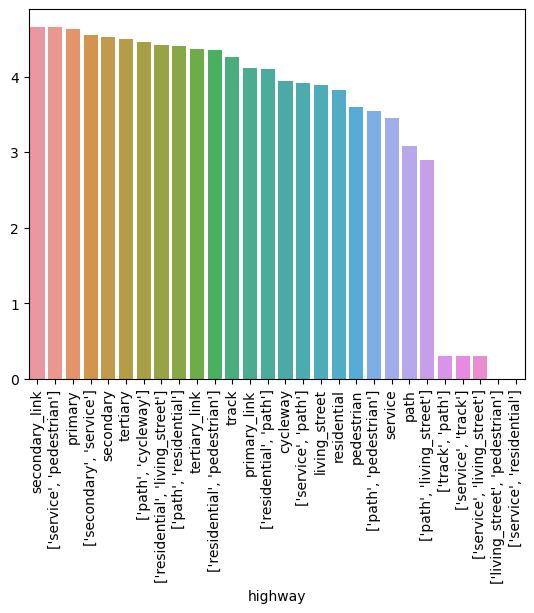

In [399]:
ax = sns.barplot(x=sorted_data.index, y=sorted_data.values)#, x=sorted_data['highway'], y=sorted_data['NACH'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [400]:
sorted_data.index

Index(['secondary_link', '['service', 'pedestrian']', 'primary',
       '['secondary', 'service']', 'secondary', 'tertiary',
       '['path', 'cycleway']', '['residential', 'living_street']',
       '['path', 'residential']', 'tertiary_link',
       '['residential', 'pedestrian']', 'track', 'primary_link',
       '['residential', 'path']', 'cycleway', '['service', 'path']',
       'living_street', 'residential', 'pedestrian', '['path', 'pedestrian']',
       'service', 'path', '['path', 'living_street']', '['track', 'path']',
       '['service', 'track']', '['service', 'living_street']',
       '['living_street', 'pedestrian']', '['service', 'residential']'],
      dtype='object', name='highway')

Text(0.5, 1.0, 'NACH35')

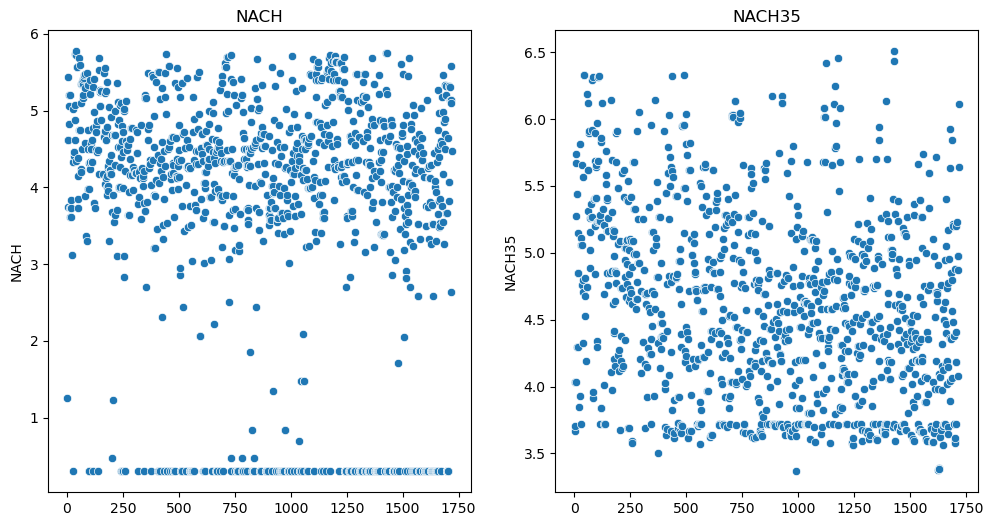

In [401]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#  NACH35 is has a radius of 1500 meters and is aligned with the average scooter movment (local perspective)
sns.scatterplot(data=gdf_raw['NACH'], ax=axes[0])
axes[0].set_title('NACH')

# NACH35 is has a radius of 3500 meters and is aligned with to overall map (global perspective)
sns.scatterplot(data=gdf_raw['NACH35'], ax=axes[1])
axes[1].set_title('NACH35')



In [402]:
gdf.head(10)

,u,v,key,osmid,name,highway,maxspeed,NACH,geometry
0,529463,30697081,0,"[142939658, 138279268]",Saarstraße,secondary,50,NaN,"LINESTRING (918605.366 6445853.650, 918550.006..."
1,529463,574492655,0,203848419,Saarstraße,primary,60,NaN,"LINESTRING (918752.964 6445858.447, 918716.763..."
2,529571,697205542,0,23658481,Goldenbrunnengasse,residential,50,1.255273,"LINESTRING (920747.364 6445633.394, 920755.357..."
3,529571,256325689,0,1105550437,Weißliliengasse,tertiary,30,3.748266,"LINESTRING (920742.221 6445691.579, 920755.357..."
4,529572,529595,0,"[202739589, 202739582]",Weißliliengasse,tertiary,30,4.616885,"LINESTRING (920596.882 6445911.508, 920590.893..."
5,529572,5424621821,1,562747837,Weißliliengasse,tertiary,30,4.616885,"LINESTRING (920589.847 6445916.859, 920586.185..."
6,529572,5424621821,0,562747836,Weißliliengasse,tertiary,30,4.616885,"LINESTRING (920548.303 6445987.757, 920547.111..."
7,529583,529591,0,"[200688930, 4614991]",Alicenstraße,primary,30,5.439374,"LINESTRING (919736.527 6445982.060, 919732.598..."
8,529583,27362740,0,"[958280520, 4614991]",Alicenstraße,primary,30,4.830781,"LINESTRING (919738.565 6445911.785, 919740.212..."
9,529583,3771859618,0,24489225,Kupferbergterrasse,residential,30,NaN,"LINESTRING (919780.332 6445908.997, 919766.595..."


In [403]:
gdf['nodes'] = list(zip(gdf['u'], gdf['v'],gdf['key'] ))

c:\Users\LukasKoch\anaconda3\envs\dksr_kgl\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [404]:
#a loop for getting the OSMids or other edge data that are represented in the NACH model
# this will be used later to merge scooter counts with the NACH model
osmids = []
for i,x in gdf.iterrows():
    try:
        osmids.append(G.get_edge_data(osmid = G.get_edge_data(gdf.iloc[0]['nodes'][0], gdf.iloc[0]['nodes'][1],gdf.iloc[0]['nodes'][2]).get('osmid')))
    except:
        try:
            osmids.append(G.get_edge_data(gdf.iloc[i]['u'],gdf.iloc[i]['v'], 1).get('osmid'))
        except:
            continue

In [405]:
#a loop for getting the OSMids or other edge data that are represented in the NACH model
# this will be used later to merge scooter counts with the NACH model
osmids = []
for i,x in gdf.iterrows():
    try:
        osmids.append(G.get_edge_data(gdf.iloc[i]['nodes'][0], gdf.iloc[i]['nodes'][1],gdf.iloc[i]['nodes'][2]).get('osmid'))
    except:
        continue

In [406]:
#check missing vallues

# the original G has about 2.7k edges
print("Original G:", len(G.edges))
#the NACH model has only about 1.7k edges
print("NACH Model:", len(gdf.index))
#lastly 1375 can mapped back on the graph, meaning some edges in the NACH model get disturbed during the process
print("Mapped Edges:", len(osmids))

Original G: 2737
NACH Model: 1720
Mapped Edges: 1366


In [407]:
#find all rows that has no corresponding edge data
def missing_data(gdf,G):
    missing_edges = []
    for i, x in gdf.iterrows():
        try:
            G.get_edge_data(gdf.iloc[i]['nodes'][0], gdf.iloc[i]['nodes'][1], gdf.iloc[i]['nodes'][2]).get('osmid')
        except:
            missing_edges.append(i)

    filtered_gdf = gdf.loc[missing_edges]
    return filtered_gdf

In [408]:
missing_data_1 = missing_data(gdf, G)

In [409]:
missing_data_1

,u,v,key,osmid,name,highway,maxspeed,NACH,geometry,nodes
1,529463,574492655,0,203848419,Saarstraße,primary,60,NaN,"LINESTRING (918752.964 6445858.447, 918716.763...","(529463, 574492655, 0)"
5,529572,5424621821,1,562747837,Weißliliengasse,tertiary,30,4.616885,"LINESTRING (920589.847 6445916.859, 920586.185...","(529572, 5424621821, 1)"
8,529583,27362740,0,"[958280520, 4614991]",Alicenstraße,primary,30,4.830781,"LINESTRING (919738.565 6445911.785, 919740.212...","(529583, 27362740, 0)"
9,529583,3771859618,0,24489225,Kupferbergterrasse,residential,30,NaN,"LINESTRING (919780.332 6445908.997, 919766.595...","(529583, 3771859618, 0)"
18,529593,697205546,0,23658217,Eppichmauergasse,residential,50,3.840984,"LINESTRING (920698.294 6445810.703, 920710.451...","(529593, 697205546, 0)"
...,...,...,...,...,...,...,...,...,...,...
1675,8495074089,8495074094,0,914493331,,cycleway,,4.563066,"LINESTRING (920103.325 6447447.831, 920092.906...","(8495074089, 8495074094, 0)"
1677,8513123713,8513123714,0,916600364,,cycleway,,5.184183,"LINESTRING (919676.972 6446605.916, 919664.003...","(8513123713, 8513123714, 0)"
1678,8513123714,8513123716,0,"[1103917080, 916600364, 1103917079]",,cycleway,,3.760649,"LINESTRING (919694.360 6446603.058, 919688.337...","(8513123714, 8513123716, 0)"
1687,8702488586,9949778891,0,939461515,,cycleway,,4.689646,"LINESTRING (918064.531 6445698.280, 918069.540...","(8702488586, 9949778891, 0)"


<Axes: >

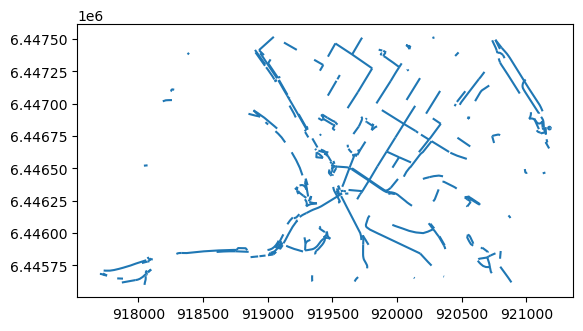

In [410]:
#missing values seem to be highly relevant
missing_data_1.plot()

In [411]:
# during export u, and v seems to be switched

def find_nodes(osmid):
    osmid = 203848419 

    # Iterate over the edges and find the matching edge
    matching_edge = None
    for u, v, key, data in G.edges(keys=True, data=True):
        if "osmid" in data and data["osmid"] == osmid:
            matching_edge = (u, v, key)
            break

    if matching_edge is not None:
        print("Matching edge found!")
        print("u:", matching_edge[0])
        print("v:", matching_edge[1])
        print("key:", matching_edge[2])
    else:
        print("No matching edge found for the given OSM ID.")

In [412]:
find_nodes(203848419)

Matching edge found!
u: 574492655
v: 529463
key: 0


In [413]:
missing_data_1[['u', 'v']] = missing_data_1[['v', 'u']]
missing_data_1['nodes'] = list(zip(missing_data_1['u'], missing_data_1['v'],missing_data_1['key'] ))

In [414]:
edges = []
for i,x in missing_data_1.iterrows():
    try:
        edges.append(G.get_edge_data(missing_data_1.iloc[i]['nodes'][0], missing_data_1.iloc[i]['nodes'][1],missing_data_1.iloc[i]['nodes'][2]))
    except:
        continue

In [415]:
len(edges)

101

In [416]:
#drop all none types
edges = [edge for edge in edges if edge is not None]

In [417]:
gdf_2 = gpd.GeoDataFrame.from_records(edges)

In [418]:
gdf_2

,osmid,oneway,name,highway,reversed,length,lanes,ref,maxspeed,geometry,bridge,access,service,tunnel,width
0,23658216,True,Eppichmauergasse,living_street,False,10.941,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
1,31294421,True,Binger Straße,primary,False,39.748,3,L 419,50,"LINESTRING (8.25636 49.99804, 8.25616 49.99783...",NaN,NaN,NaN,NaN,NaN
2,146665780,True,Hintere Bleiche,residential,False,11.352,NaN,NaN,30,"LINESTRING (8.26193 50.00012, 8.26198 50.00017...",NaN,NaN,NaN,NaN,NaN
3,127812106,True,Dr.-Martin-Luther-King-Weg,tertiary_link,False,21.162,1,K 4,50,"LINESTRING (8.24739 49.99721, 8.24731 49.99723...",NaN,NaN,NaN,NaN,NaN
4,31394863,True,Bahnhofstraße,service,False,103.671,NaN,NaN,20,"LINESTRING (8.26258 50.00078, 8.26160 50.00120...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,407710145,True,NaN,service,False,8.509,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
94,202707502,True,Mombacher Straße,secondary,False,17.422,2,K 17,50,None,NaN,NaN,NaN,NaN,NaN
95,580066709,True,NaN,service,False,10.797,NaN,NaN,NaN,"LINESTRING (8.25005 50.00645, 8.25002 50.00643...",NaN,NaN,NaN,NaN,NaN
96,23595731,True,Kaiser-Wilhelm-Ring,residential,False,11.871,NaN,NaN,30,"LINESTRING (8.25640 50.00538, 8.25635 50.00537...",NaN,NaN,NaN,NaN,NaN


In [335]:
gdf_2 = gpd.GeoDataFrame(edges)

In [339]:
gdf_2[0]

0                                                   None
1      {'osmid': 23658216, 'oneway': True, 'name': 'E...
2      {'osmid': 31294421, 'oneway': True, 'lanes': '...
3      {'osmid': 146665780, 'oneway': True, 'name': '...
4      {'osmid': 127812106, 'oneway': True, 'lanes': ...
                             ...                        
96     {'osmid': 580066709, 'oneway': True, 'highway'...
97                                                  None
98                                                  None
99     {'osmid': 23595731, 'oneway': True, 'name': 'K...
100    {'osmid': 939461515, 'oneway': True, 'highway'...
Name: 0, Length: 101, dtype: object

In [342]:
df = pd.DataFrame(gdf_2[0].tolist()) 
gdf_normalized = gpd.GeoDataFrame(df)

In [347]:
gdf = gpd.GeoDataFrame.from_records(edges)

TypeError: 'NoneType' object is not iterable

In [343]:
gdf_normalized

,0
0,None
1,"{'osmid': 23658216, 'oneway': True, 'name': 'E..."
2,"{'osmid': 31294421, 'oneway': True, 'lanes': '..."
3,"{'osmid': 146665780, 'oneway': True, 'name': '..."
4,"{'osmid': 127812106, 'oneway': True, 'lanes': ..."
...,...
96,"{'osmid': 580066709, 'oneway': True, 'highway'..."
97,None
98,None
99,"{'osmid': 23595731, 'oneway': True, 'name': 'K..."


In [213]:
G.get_edge_data(574492655, 529463, 0)

{'osmid': 203848419,
 'oneway': True,
 'lanes': '3',
 'ref': 'L 419',
 'name': 'Saarstraße',
 'highway': 'primary',
 'maxspeed': '60',
 'reversed': False,
 'length': 94.856,
 'geometry': <LINESTRING (8.253 49.998, 8.253 49.998, 8.253 49.998, 8.252 49.998, 8.252 4...>}

In [45]:
edges_outview = list(G.edges)

In [46]:
edges_outviewedges_set = set(edges_outview)

In [47]:
gdf_edges_set = set(zip(gdf['u'], gdf['v']))

In [48]:
missing_edges = edges_set - gdf_edges_set

NameError: name 'edges_set' is not defined

In [ ]:
missing_edges = list(missing_edges)

edge_info = []
for i in missing_edges:
    try:
        edge_info.append(G.get_edge_data(missing_edges[0][0],missing_edges[0][1],missing_edges[0][2]))
    except:
        continue

In [ ]:
#edge_info

In [54]:
df.head(2)

,trip_id,end_time,coordinates,vehicle_type,accuracy,trip_distance,propulsion_types,SID,start_time,timestamps_list,trip_duration,vehicle_id,timestamp,_headers.eventType
0,9d31d68b-2e85-427d-afde-3b595964d640,1684051266022,"[[8.249413, 50.011144], [8.249553, 50.011028],...",scooter,8.0,2543.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1684050749971,"[1684050749000, 1684050761000, 1684050772000, ...",516.0,419231,2023-05-14T09:35:25.654Z,MdsTierEventType
1,f6f65581-a8d6-4a4c-a943-2861ac0e280f,1684051603889,"[[8.260748, 50.000623], [8.26068, 50.000586], ...",scooter,8.0,1111.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1684051354414,"[1684051354000, 1684051366000, 1684051377000, ...",249.0,409805,2023-05-14T09:35:25.654Z,MdsTierEventType


In [ ]:
df['drop_off_lon'] = df['coordinates'].apply(lambda x: x[-1][0])
df['drop_off_lat'] = df['coordinates'].apply(lambda x: x[-1][1])

df['start_lon'] = df['coordinates'].apply(lambda x: x[0][0])
df['start_lat'] = df['coordinates'].apply(lambda x: x[0][1])

In [ ]:
# Get the nearest nodes for start and drop-off locations
df['start_node'] = df.apply(lambda row: ox.nearest_nodes(G, row['start_lon'], row['start_lat']), axis=1)
df['dropoff_node'] = df.apply(lambda row: ox.nearest_nodes(G, row['drop_off_lon'], row['drop_off_lat']), axis=1)

In [ ]:
def get_edges(data):
    #data = np.array(data)
    edges = ox.nearest_edges(G,[k[0] for k in data], [k[1] for k in data])    
    edges = list(dict.fromkeys(edges))
    edges = [k[0:2] for k in edges]
    return edges

In [183]:
df

,trip_id,end_time,coordinates,trip_distance,start_time,timestamps_list,trip_duration,vehicle_id,drop_off_lon,drop_off_lat,start_lon,start_lat,start_node,dropoff_node
0,9d31d68b-2e85-427d-afde-3b595964d640,1684051266022,"[[8.249413, 50.011144], [8.249553, 50.011028],...",2543.0,1684050749971,"[1684050749000, 1684050761000, 1684050772000, ...",516.0,419231,8.246656,49.999895,8.249413,50.011144,3905348265,1290219834
1,f6f65581-a8d6-4a4c-a943-2861ac0e280f,1684051603889,"[[8.260748, 50.000623], [8.26068, 50.000586], ...",1111.0,1684051354414,"[1684051354000, 1684051366000, 1684051377000, ...",249.0,409805,8.247226,49.998968,8.260748,50.000623,566717121,1290219857
2,2e1996b4-b98b-450d-9ae6-13b09f36a22c,1684052428766,"[[8.260676, 50.000629], [8.260725, 50.00063], ...",1074.0,1684052143110,"[1684052143000, 1684052153000, 1684052164000, ...",286.0,402628,8.253082,50.008255,8.260676,50.000629,566717121,255380780
3,73175c59-6e40-4a83-acf6-c3b70e95b3ea,1684051820349,"[[8.258476, 49.999292], [8.258477, 49.999293],...",1000.0,1684051575768,"[1684051575000, 1684051588000, 1684051599000, ...",245.0,419979,8.247215,49.995899,8.258476,49.999292,697194350,581999881
4,8d9d9ffe-c3f0-4912-baaf-dd4439fa8ac9,1684051675478,"[[8.255235, 50.007574], [8.255233, 50.007573],...",2638.0,1684051137536,"[1684051137000, 1684051138000, 1684051139000, ...",538.0,403076,8.227288,50.011901,8.255235,50.007574,30651659,3470354147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,bfa10877-09c8-4edb-8a23-eeec0f2ac5be,1684073575510,"[[8.24718, 49.995682], [8.247179, 49.995688], ...",4413.0,1684072709678,"[1684072709000, 1684072717000, 1684072728000, ...",866.0,419231,8.289820,49.980944,8.247180,49.995682,581999881,255141628
257,fb4e3f99-9fcd-44ff-bd2f-79119ca05f9c,1684074981298,"[[8.248372, 49.977951], [8.248445, 49.977992],...",5244.0,1684073748159,"[1684073748000, 1684073760000, 1684073772000, ...",1233.0,415584,8.301250,49.981799,8.248372,49.977951,5837379323,253750790
258,c2232f0c-c209-49e7-8ee1-9a94eec9d619,1684074829269,"[[8.27143, 49.973331], [8.271428, 49.973337], ...",1314.0,1684074557992,"[1684074557000, 1684074569000, 1684074579000, ...",271.0,420457,8.279795,49.963438,8.271430,49.973331,255141628,255141628
259,875cb832-7410-4c83-890e-d998356d638e,1684074093061,"[[8.254694, 50.015542], [8.254697, 50.01554], ...",6558.0,1684072475505,"[1684072475000, 1684072475000, 1684072496000, ...",1618.0,423683,8.308749,49.980167,8.254694,50.015542,30651659,253750790


In [40]:
# Extract the routes and their lengths
routes = list(df['route'])
lengths = [nx.shortest_path_length(G, start_node, dropoff_node, weight='length') for start_node, dropoff_node in zip(df['start_node'], df['dropoff_node'])]


KeyError: 'route'

In [ ]:
# Step 1: Calculate betweeness centraliy for every edge and assign to string
# Alternative: replace varibale 'lenght' in G with values from betweenes centrality


len(lengths)

NameError: name 'lengths' is not defined

In [24]:
edge_betweenness = nx.edge_betweenness_centrality(G)

KeyboardInterrupt: 

In [26]:
df.head()

,trip_id,end_time,coordinates,trip_distance,start_time,timestamps_list,trip_duration,vehicle_id,drop_off_lon,drop_off_lat,start_lon,start_lat,start_node,dropoff_node,route,shortestPath_length,path_coeff,shortestPath
0,9d31d68b-2e85-427d-afde-3b595964d640,1684051266022,"[[8.249413, 50.011144], [8.249553, 50.011028],...",2543.0,1684050749971,"[1684050749000, 1684050761000, 1684050772000, ...",516.0,419231,8.246656,49.999895,8.249413,50.011144,5153322722,1290219834,"[5153322722, 5153320608, 8493775418, 849377501...",2187.140,1.162706,"[(8.2493053, 50.011189), (8.2498574, 50.010647..."
1,f6f65581-a8d6-4a4c-a943-2861ac0e280f,1684051603889,"[[8.260748, 50.000623], [8.26068, 50.000586], ...",1111.0,1684051354414,"[1684051354000, 1684051366000, 1684051377000, ...",249.0,409805,8.247226,49.998968,8.260748,50.000623,566717121,1290219857,"[566717121, 1599319855, 1413508308, 1416745300...",1120.226,0.991764,"[(8.2606947, 50.0004728), (8.2605681, 50.00035..."
2,2e1996b4-b98b-450d-9ae6-13b09f36a22c,1684052428766,"[[8.260676, 50.000629], [8.260725, 50.00063], ...",1074.0,1684052143110,"[1684052143000, 1684052153000, 1684052164000, ...",286.0,402628,8.253082,50.008255,8.260676,50.000629,566717121,255306703,"[566717121, 1192750581, 1416745324, 3732195296...",1062.568,1.010759,"[(8.2606947, 50.0004728), (8.2600519, 50.00103..."
3,73175c59-6e40-4a83-acf6-c3b70e95b3ea,1684051820349,"[[8.258476, 49.999292], [8.258477, 49.999293],...",1000.0,1684051575768,"[1684051575000, 1684051588000, 1684051599000, ...",245.0,419979,8.247215,49.995899,8.258476,49.999292,697194350,2790458842,"[697194350, 697194345, 1413872817, 1413872833,...",1072.544,0.932363,"[(8.2582396, 49.9992564), (8.2577599, 49.99905..."
4,8d9d9ffe-c3f0-4912-baaf-dd4439fa8ac9,1684051675478,"[[8.255235, 50.007574], [8.255233, 50.007573],...",2638.0,1684051137536,"[1684051137000, 1684051138000, 1684051139000, ...",538.0,403076,8.227288,50.011901,8.255235,50.007574,5101217129,697222827,"[5101217129, 7124145112, 30651659, 30651660, 7...",3195.504,0.825535,"[(8.2552037, 50.0075596), (8.2557166, 50.00728..."


In [15]:
# G.add_weighted_edges_from

In [19]:
df['shortestPath_length'] = pd.Series(lengths)
df['path_coeff'] = df['trip_distance']/df['shortestPath_length']

In [21]:
df['shortestPath'] = pd.Series([[(G.nodes[node]['x'], G.nodes[node]['y']) for node in route] for route in routes])

In [22]:
df

,trip_id,end_time,coordinates,trip_distance,start_time,timestamps_list,trip_duration,vehicle_id,drop_off_lon,drop_off_lat,start_lon,start_lat,start_node,dropoff_node,route,shortestPath_length,path_coeff,shortestPath
0,9d31d68b-2e85-427d-afde-3b595964d640,1684051266022,"[[8.249413, 50.011144], [8.249553, 50.011028],...",2543.0,1684050749971,"[1684050749000, 1684050761000, 1684050772000, ...",516.0,419231,8.246656,49.999895,8.249413,50.011144,5153322722,1290219834,"[5153322722, 5153320608, 8493775418, 849377501...",2187.140,1.162706,"[(8.2493053, 50.011189), (8.2498574, 50.010647..."
1,f6f65581-a8d6-4a4c-a943-2861ac0e280f,1684051603889,"[[8.260748, 50.000623], [8.26068, 50.000586], ...",1111.0,1684051354414,"[1684051354000, 1684051366000, 1684051377000, ...",249.0,409805,8.247226,49.998968,8.260748,50.000623,566717121,1290219857,"[566717121, 1599319855, 1413508308, 1416745300...",1120.226,0.991764,"[(8.2606947, 50.0004728), (8.2605681, 50.00035..."
2,2e1996b4-b98b-450d-9ae6-13b09f36a22c,1684052428766,"[[8.260676, 50.000629], [8.260725, 50.00063], ...",1074.0,1684052143110,"[1684052143000, 1684052153000, 1684052164000, ...",286.0,402628,8.253082,50.008255,8.260676,50.000629,566717121,255306703,"[566717121, 1192750581, 1416745324, 3732195296...",1062.568,1.010759,"[(8.2606947, 50.0004728), (8.2600519, 50.00103..."
3,73175c59-6e40-4a83-acf6-c3b70e95b3ea,1684051820349,"[[8.258476, 49.999292], [8.258477, 49.999293],...",1000.0,1684051575768,"[1684051575000, 1684051588000, 1684051599000, ...",245.0,419979,8.247215,49.995899,8.258476,49.999292,697194350,2790458842,"[697194350, 697194345, 1413872817, 1413872833,...",1072.544,0.932363,"[(8.2582396, 49.9992564), (8.2577599, 49.99905..."
4,8d9d9ffe-c3f0-4912-baaf-dd4439fa8ac9,1684051675478,"[[8.255235, 50.007574], [8.255233, 50.007573],...",2638.0,1684051137536,"[1684051137000, 1684051138000, 1684051139000, ...",538.0,403076,8.227288,50.011901,8.255235,50.007574,5101217129,697222827,"[5101217129, 7124145112, 30651659, 30651660, 7...",3195.504,0.825535,"[(8.2552037, 50.0075596), (8.2557166, 50.00728..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,bfa10877-09c8-4edb-8a23-eeec0f2ac5be,1684073575510,"[[8.24718, 49.995682], [8.247179, 49.995688], ...",4413.0,1684072709678,"[1684072709000, 1684072717000, 1684072728000, ...",866.0,419231,8.289820,49.980944,8.247180,49.995682,2790458842,6327562196,"[2790458842, 5149839135, 581999896, 6461087785...",4242.453,1.040200,"[(8.2470682, 49.995711), (8.247153, 49.9965166..."
257,fb4e3f99-9fcd-44ff-bd2f-79119ca05f9c,1684074981298,"[[8.248372, 49.977951], [8.248445, 49.977992],...",5244.0,1684073748159,"[1684073748000, 1684073760000, 1684073772000, ...",1233.0,415584,8.301250,49.981799,8.248372,49.977951,698155891,2022697359,"[698155891, 698155895, 698155913, 1587590997, ...",4630.462,1.132500,"[(8.2482136, 49.9779092), (8.2491534, 49.97794..."
258,c2232f0c-c209-49e7-8ee1-9a94eec9d619,1684074829269,"[[8.27143, 49.973331], [8.271428, 49.973337], ...",1314.0,1684074557992,"[1684074557000, 1684074569000, 1684074579000, ...",271.0,420457,8.279795,49.963438,8.271430,49.973331,2166219386,3408299613,"[2166219386, 220123356, 761145104, 761145117, ...",1323.800,0.992597,"[(8.2718149, 49.9730681), (8.2714609, 49.97290..."
259,875cb832-7410-4c83-890e-d998356d638e,1684074093061,"[[8.254694, 50.015542], [8.254697, 50.01554], ...",6558.0,1684072475505,"[1684072475000, 1684072475000, 1684072496000, ...",1618.0,423683,8.308749,49.980167,8.254694,50.015542,9688008486,34580659,"[9688008486, 255323752, 697199267, 10068059108...",5755.957,1.139341,"[(8.254164, 50.0157467), (8.2555923, 50.015006..."
